In [1]:
import logging
import warnings

import numpy as np

np.set_printoptions(precision=4)
warnings.filterwarnings("ignore")


logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Temperature independent negative logarithm of average observable

This type of extrapolation is useful for extrapolating hard-sphere chemical potentials in temperature or volume, or other quantities involving logarithms of probabilities (e.g. PMFs).

This is in fact easier than Case 2 because we do not need to augment the data in any way - we just set a flag that the quantity to extrapolate is the negative logarithm of an ensemble average, i.e., `post_func = 'minus_log'`. Note, though, that we handled the -log calculation in the definition of the derivatives (even at zeroth order). This means we want to just pass data, not the -log of the data. Also note that `post_func` can take any function utilizing sympy expressions for modifying the *average* observable we want to extrapolate, so passing `post_func = lambda x: -sympy.log(x)` would be equivalent. If you're applying the function to the observable itself, that's just a different observable and you don't need to worry about what we're doing in this notebook... it's the difference between $\ln \langle x \rangle$ and $\langle \ln x \rangle$.

In [2]:
%matplotlib inline

import cmomy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Import idealgas module
from thermoextrap import idealgas

rng = cmomy.random.default_rng(seed=0)

# Define test betas and reference beta
betas = np.arange(0.1, 10.0, 0.5)
beta_ref = betas[11]
vol = 1.0

# Define orders to extrapolate to
orders = [1, 2, 4, 6]
order = orders[-1]

npart = 1000  # Number of particles (in single configuration)
nconfig = 100_000  # Number of configurations

# Generate all the data we could want
xdata, udata = idealgas.generate_data((nconfig, npart), beta_ref, vol)

In [3]:
import thermoextrap as xtrap

In [4]:
# Create and train extrapolation model
xem_log = xtrap.beta.factory_extrapmodel(
    beta=beta_ref,
    post_func="minus_log",
    data=xtrap.DataCentralMomentsVals.from_vals(
        order=orders[-1],
        xv=xr.DataArray(xdata, dims="rec"),
        uv=xr.DataArray(udata, dims="rec"),
        deriv_dim=None,
        central=True,
    ),
)

# Check the derivatives
print("Model parameters (derivatives):")
print(xem_log.derivs(norm=False))
print("\n")

# Finally, look at predictions
print("Model predictions:")
print(xem_log.predict(betas[:4], order=2))
print("\n")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Model parameters (derivatives):


<xarray.DataArray (order: 7)> Size: 56B
array([ 1.7438,  0.1615, -0.0186,  0.015 ,  0.612 , -1.9426, -1.9077])
Dimensions without coordinates: order


Model predictions:
<xarray.DataArray (beta: 4)> Size: 32B
array([0.5741, 0.7037, 0.8286, 0.9489])
Coordinates:
  * beta     (beta) float64 32B 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 32B -5.5 -5.0 -4.5 -4.0
    beta0    float64 8B 5.6




In [5]:
# And bootstrapped uncertainties
print("Bootstrapped uncertainties in predictions:")
print(xem_log.resample(sampler={"nrep": 100}).predict(betas[:4], order=3).std("rep"))

Bootstrapped uncertainties in predictions:


<xarray.DataArray (beta: 4)> Size: 32B
array([2.0496, 1.54  , 1.1227, 0.7887])
Coordinates:
  * beta     (beta) float64 32B 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 32B -5.5 -5.0 -4.5 -4.0
    beta0    float64 8B 5.6


True extrapolation coefficients: [ 1.7438e+00  1.6106e-01 -1.7727e-02  3.6676e-04  2.1114e-03 -1.5377e-03
  3.9927e-04]
	 With N_configs = 10: [ 1.7469e+00  1.1364e-01  1.3435e-01 -8.7672e-01 -1.8012e+01 -1.0596e+02
  3.2007e+03]


	 With N_configs = 100: [ 1.7423e+00  1.3459e-01 -1.9823e-01  1.2182e+00 -1.0755e+01 -6.0855e+01
  3.2539e+03]
	 With N_configs = 1000: [ 1.7426  0.1588 -0.0696 -0.1739  0.8373 46.7624 56.4464]
	 With N_configs = 10000: [  1.7436   0.161   -0.0531  -0.2102   4.1724 -23.4454  22.6547]
	 With N_configs = 100000: [ 1.7438  0.1615 -0.0186  0.015   0.612  -1.9426 -1.9077]


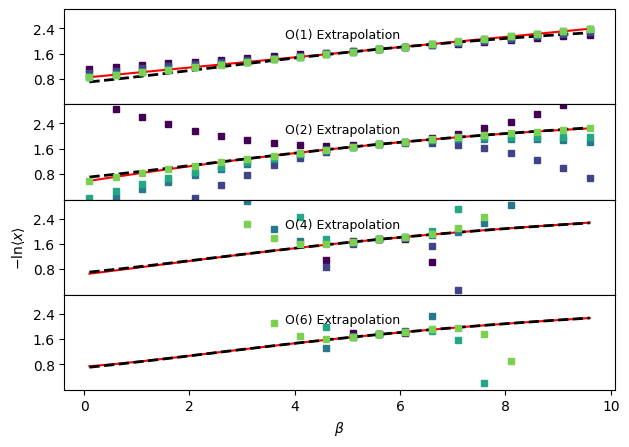

In [6]:
# Repeat comparison of results, but for -ln<x> instead of <x>

fig, ax = plt.subplots(len(orders), sharex=True, sharey=True)

nsampvals = np.array((10.0 * np.ones(5)) ** np.arange(1, 6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0 / len(nsampvals))))

# First plot the analytical result
for a in ax:
    a.plot(betas, -np.log(idealgas.x_ave(betas, vol)), "k--", linewidth=2.0)

# Next look at extrapolation with an infinite number of samples
# This is possible in the ideal gas model in both temperature and volume
for j, o in enumerate(orders):
    trueExtrap, trueDerivs = idealgas.x_beta_extrap_minuslog(o, beta_ref, betas, vol)
    ax[j].plot(betas, trueExtrap, "r-", zorder=0)
    if j == len(orders) - 1:
        print(f"True extrapolation coefficients: {trueDerivs}")

for i, n in enumerate(nsampvals):
    thisinds = rng.choice(len(xdata), size=n, replace=False)

    # Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    xem_log = xtrap.beta.factory_extrapmodel(
        beta=beta_ref,
        post_func="minus_log",
        data=xtrap.DataCentralMomentsVals.from_vals(
            order=orders[-1],
            uv=xr.DataArray(udata[thisinds], dims="rec"),
            xv=xr.DataArray(xdata[thisinds], dims="rec"),
            central=True,
        ),
    )
    out = xem_log.predict(betas, cumsum=True)
    print(
        f"\t With N_configs = {n}: {xem_log.derivs(norm=False).values.flatten()}"
    )  # Have to flatten because observable is 1-D
    for j, o in enumerate(orders):
        out.sel(order=o).plot(
            marker="s",
            ms=4,
            color=nsampcolors[i],
            ls="None",
            label=f"N={n}",
            ax=ax[j],
        )

ax[2].set_ylabel(r"$-\mathrm{ln} \langle x \rangle$")
ax[-1].set_xlabel(r"$\beta$")

for j, o in enumerate(orders):
    ax[j].annotate(
        f"O({o}) Extrapolation", xy=(0.4, 0.7), xycoords="axes fraction", fontsize=9
    )

ax[0].set_ylim((0.0, 3.0))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune="both"))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

for a in ax:
    a.set_title(None)

plt.show()